In [64]:
import uproot
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
def ttbar_plot(log_number, plot_type, ax = None, plot_label = "", normalize = False):
    """
    Plot some useful quantities:
        nParticles: number of particles in the event
        m_tt: mass of the generated ttbar system
        m_total: mass of the central system (from generated protons)
        m_frac: m_tt/m_total
    """
    summaryfile_path = "LOG/"+str(log_number)+"/"
    rootfile_path = "ROOT/"+str(log_number)+"/"
    rootfile_filepath = rootfile_path+os.listdir(rootfile_path)[0]
    rootfile = uproot.open(rootfile_filepath)
    
    lumiTot = 300 #fb^-1
    sqrt_s = 0 #GeV
    xsec = 0 #fb
    with open(summaryfile_path+"Summary.txt") as dc:
            for line in dc: 
                if line.startswith("ECMS"):
                    sqrt_s = float(line.split()[1])
                if line.startswith(" Cross"):
                    xsec = float(line.split()[2]) * 1000 #transform in fb
                    
    events = rootfile["LHEF"]
    branchlist = [
     'Particle.PID',
     'Particle.Px',
     'Particle.Py',
     'Particle.Pz',
     'Particle.E',
     'Particle.M',
     'Particle.PT',
     'Particle.Eta',
     'Particle.Phi',
     'Particle.Rapidity']
    events_df = events.pandas.df(branchlist,flatten=True)
    
    n_events = len(events_df.groupby(level=0))
    scale_factor = (xsec*lumiTot)/n_events 
    
    if not normalize:
        scale_factor = 1
        
    print("Cross section: ", xsec, "fb")
    print("Number of events: ", n_events)
    print("Scale factor: ", scale_factor)
    nParticles = []
    for entry,entry_df in events_df.groupby(level=0):
        nParticles.append(len(entry_df))
        PIDs = entry_df[["Particle.PID"]].to_numpy()
        if not all(elem in PIDs for elem in [6,-6,2212]):
            events_df = events_df.drop(entry)
            print("Dropping entry: "+str(entry))
            
    tops = events_df[ events_df["Particle.PID"] == 6]
    atops = events_df[ events_df["Particle.PID"] == -6]
    tops_lorentzVector = tops[["Particle.Px","Particle.Py","Particle.Pz","Particle.E"]].to_numpy()
    atops_lorentzVector = atops[["Particle.Px","Particle.Py","Particle.Pz","Particle.E"]].to_numpy()
    ttbars_lorentzVector = tops_lorentzVector + atops_lorentzVector
    ttbars_masses = np.sqrt( ttbars_lorentzVector[:,3]**2 - (ttbars_lorentzVector[:,0]**2 + ttbars_lorentzVector[:,1]**2 + ttbars_lorentzVector[:,2]**2) )
    protonP = events_df[ (events_df["Particle.PID"] == 2212) & (events_df["Particle.Pz"] > 0) ]
    protonN = events_df[ (events_df["Particle.PID"] == 2212) & (events_df["Particle.Pz"] < 0) ]
    protonP_xi = (1 - protonP[["Particle.Pz"]].to_numpy()/(sqrt_s/2))[:,0]
    protonN_xi = (1 + protonN[["Particle.Pz"]].to_numpy()/(sqrt_s/2))[:,0]
    m_total = np.sqrt((sqrt_s**2) * protonP_xi * protonN_xi)
    m_frac = ttbars_masses / m_total
    
    if ax == None:
        fig, ax = plt.subplots()
    if plot_type == "nParticles":
        h_nParticles = ax.hist(nParticles, bins=10, label = plot_label, weights = np.ones_like(nParticles) * scale_factor)
        plt.xlabel('Number of Particles')
    elif plot_type == "m_tt":
        h_mtt = ax.hist(ttbars_masses, bins=40, label = plot_label, weights = np.ones_like(ttbars_masses) * scale_factor)
        plt.xlabel('m_tt (GeV)')
    elif plot_type == "m_total":
        h_m_total = ax.hist(m_total, bins=40, label = plot_label, weights = np.ones_like(m_total) * scale_factor)
        plt.xlabel('m_total (GeV)')
    elif plot_type == "m_frac":
        h_m_frac = ax.hist(m_frac, bins=40,histtype='step', fill=None, label = plot_label, weights = np.ones_like(m_frac) * scale_factor)
        plt.xlabel('m_frac')
    else:
        print("Plot type not available")
        sys.exit(1)


Cross section:  14.02904124902162 fb
Number of events:  10000
Scale factor:  0.4208712374706486
Dropping entry: 1557


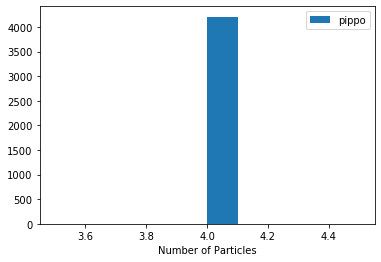

In [58]:
fig, ax = plt.subplots()
ttbar_plot(17,"nParticles",ax,"pippo",True)
plt.legend()

In [66]:
sim_IDs = [56,57,58,59,60]

Analyzing ID: 56 GLU_NU =  -1.0
Cross section:  59.62123753685284 fb
Number of events:  10000
Scale factor:  1.7886371261055851

Analyzing ID: 57 GLU_NU =  -0.5
Cross section:  26.440797678723612 fb
Number of events:  10000
Scale factor:  0.7932239303617084
Dropping entry: 1018

Analyzing ID: 58 GLU_NU =  0.0
Cross section:  14.02904124902162 fb
Number of events:  10000
Scale factor:  0.4208712374706486
Dropping entry: 1557

Analyzing ID: 59 GLU_NU =  0.5
Cross section:  8.415893843933059 fb
Number of events:  10000
Scale factor:  0.25247681531799177
Dropping entry: 2919

Analyzing ID: 60 GLU_NU =  1.0
Cross section:  5.573340265560713 fb
Number of events:  10000
Scale factor:  0.1672002079668214
Dropping entry: 2279



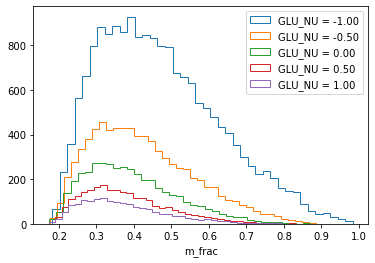

In [67]:
fig, ax = plt.subplots()
for ID in sim_IDs:
    summaryfile_path = "LOG/"+str(ID)+"/"
    with open(summaryfile_path+"Summary.txt") as dc:
            for line in dc: 
                if line.startswith("GLU_NU"):
                    GLU_NU = float(line.split()[1])
    print("Analyzing ID:",ID, "GLU_NU = ", GLU_NU)
    ttbar_plot(ID,"m_frac",ax, "GLU_NU = {:.2f}".format(GLU_NU),normalize = True)
    print()
plt.legend()